# Credit Card Customer Churn - EDA & Modelling

## Table of content
* [1. Introduction](#Introduction)
    * [1.1. Goals](#Goals)
    * [1.2. Libraries](#Libraries)
* [2. The Data](#TheData)
    * [2.1. Data Sample](#DataSample)
    * [2.2. Data Preprocessing](#DataPreprocessing)
* [3. Customer Profiles](#CustomerProfiles)
    * [3.1. Exploratory Data Analysis](#EDA)
    * [3.2. Churn and Non Churn Profiles](#Profiles)
* [4. Customer Churn Prediction](#CustomerChurnPrediction)
    * [4.1. Data Preperation](#DataPrep)
    * [4.2. Model Training](#ModelTraining)
    * [4.3. Model Evaluation](#ModelEvaluation)
    * [4.4. Hyperparameter tuning](#Hyperparameter)
    * [4.5. Feature Importance](#FeatureImportance)
* [5. Conclusion](#Conclusion)


<a id="introduction"></a>
# 1. Introduction

<a id="Goals"></a>
## 1.1. Goals
The goal of this notebook is to answer both tasks given for the ["Credit Card Customers"](https://www.kaggle.com/sakshigoyal7/credit-card-customers/tasks) - dataset.

The first goal of this project is to provide an analysis which shows the **difference** between a **non-churning and churning customer**. This will provide us insight into which customers are eager to churn.

The top priority of this case is to identify if a customer will churn or won't. It's important that we don't **predict** churning as non-churning customers. That's why the model needs to be evaluated on the **"Recall"**- metric (goal > 62%).

<a id="Libraries"></a>
## 1.2. Libraries
Libraries used can be found in the code block underneed.

In [1]:
!pip install imbalanced-learn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Libraries
import os

# Used for EDA, Customer profiling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

from scipy import stats
from scipy.stats import randint
from scipy.stats import uniform


# Presets
%matplotlib inline
sns.set()

<a id=TheData></a>
# 2. The Data
<a id="DataSample"></a>
## 2.1. Data sample

The building block of any data science project is the data. Underneed you can find one data record which will be used in further analysis. The dataset consist of 10000 samples describing the customers and it's behavior.

The following columns/features can be split up in the following groups:

* ***Basic information***:
    * **CLIENTNUM** : Unique identifier for the customer holding the account.


* ***Target/Label***:
    * **Attrition_Flag**: Internal event (customer activity) variable - if the account is closed then 1 else 0.


* ***Demographic variables***:
    * **Customer_Age**: Demographic variable - Customer's Age in Years.
    * **Gender**: Demographic variable - M=Male, F=Female.
    * **Dependent_count**: Demographic variable - Number of dependents.
    * **Education_Level**: Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.).
    * **Marital_Status**: Demographic variable - Married, Single, Divorced, Unknown.
    * **Income_Category**: Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, >).
    

* ***Product variables***:
    * **Card_Category**: Product Variable - Type of Card (Blue, Silver, Gold, Platinum).
    * **Months_on_book**: Period of relationship with bank.
    * **Total_Relationship_Count**: Total no. of products held by the customer.
    * **Months_Inactive_12_mon**: No. of Months in the last 12 months.
    * **Contacts_Count_12_mon**: No. of Contacts in the last 12 months.
    * **Credit_Limit**: Credit Limit on the Credit Card.
    * **Total_Revolving_Bal**: Total Revolving Balance on the Credit Card.
    * **Avg_Open_To_Buy**: Open to Buy Credit Line (Average of last 12 months
    * **Total_Amt_Chng_Q4_Q1**: Change in Transaction Amount (Q4 over Q1).
    * **Total_Trans_Amt**: Total Transaction Amount (Last 12 months).
    * **Total_Trans_Ct**: Total Transaction Count (Last 12 months).
    * **Total_Ct_Chng_Q4_Q1**: Change in Transaction Count (Q4 over Q1).
    * **Avg_Utilization_Ratio**: Average Card Utilization Ratio.


* ***Unimportant variables***:
    * **Naive_Bayes**: It was mentioned that all columns containing the "N.B."-tag should be disregarded.


In [3]:
data = pd.read_csv('/kaggle/input/credit-card-customers/BankChurners.csv')
data.head(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


<a id="DataPreprocessing" ></a>
## 2.2. Data Preprocessing
In this phase we'll quickly explore the data and remove/impute incorrect values. So that a cleaned data can be used for further analysis/modelling.

* Remove unnecessary columns.
* Check for duplicates.
* Change ID to client number.
* Check for null values.



### Remove N.B. columns

In [4]:
# Removing the N.B. columns
data = data.drop(columns= ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])

In [5]:
for column in data.columns:
    print("Column name: " + column)

print("Column count: " + str(len(data.columns)))

Column name: CLIENTNUM
Column name: Attrition_Flag
Column name: Customer_Age
Column name: Gender
Column name: Dependent_count
Column name: Education_Level
Column name: Marital_Status
Column name: Income_Category
Column name: Card_Category
Column name: Months_on_book
Column name: Total_Relationship_Count
Column name: Months_Inactive_12_mon
Column name: Contacts_Count_12_mon
Column name: Credit_Limit
Column name: Total_Revolving_Bal
Column name: Avg_Open_To_Buy
Column name: Total_Amt_Chng_Q4_Q1
Column name: Total_Trans_Amt
Column name: Total_Trans_Ct
Column name: Total_Ct_Chng_Q4_Q1
Column name: Avg_Utilization_Ratio
Column count: 21


### Check for duplicates and change ID to ClientNumber

In [6]:
# True if duplicates are present
data.duplicated().any()

False

In [7]:
# Change the ID to the ClientNumber
data = data.set_index("CLIENTNUM")

### Null values?

In [8]:
# Describe columns
data.isnull().any()

Attrition_Flag              False
Customer_Age                False
Gender                      False
Dependent_count             False
Education_Level             False
Marital_Status              False
Income_Category             False
Card_Category               False
Months_on_book              False
Total_Relationship_Count    False
Months_Inactive_12_mon      False
Contacts_Count_12_mon       False
Credit_Limit                False
Total_Revolving_Bal         False
Avg_Open_To_Buy             False
Total_Amt_Chng_Q4_Q1        False
Total_Trans_Amt             False
Total_Trans_Ct              False
Total_Ct_Chng_Q4_Q1         False
Avg_Utilization_Ratio       False
dtype: bool

No null values are found.

<a id="CustomerProfiles"></a>
# 3. Customer Profiles
Let's now explore and understand our data! 
<a id="EDA"></a>
## 3.1. Exploratory Data Analysis (EDA)

EDA tasks:

* Check the target variable:
    * Amount of attrition.


* Check the demographic variables:
    * Age vs attrition.
    * Gender vs churn.
    * Number of dependents vs churn.
    * Education level vs churn.
    * Marital status vs churn.
    * Income category vs churn.


* Check the product variables:
    * Type of card vs churn.
    * Relationship with the bank vs churn.
    * Number of products vs churn.
    * Inactive months vs churn.
    * Number of contacts vs churn.
    * Credit Limit vs churn.
    * Total resolving balance vs churn.
    * Openness To Buy Credit Line vs churn.
    * Transaction Amount Change vs churn.
    * Transaction Count Change vs churn.
    * Average Card Utilization Ratio vs churn.

--> click [here](#Profiles) to skip forward to the profiling result!


## Check the target variable
### Amount of churned customers
How many customers have churned?

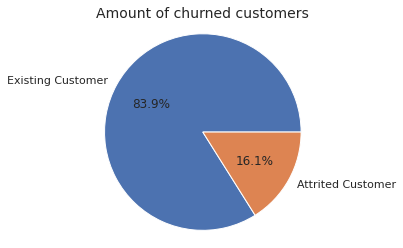

In [9]:
target = data["Attrition_Flag"].value_counts()

fig1, ax1 = plt.subplots()

ax1.pie(target, labels=target.index, autopct='%1.1f%%', shadow=None)
ax1.axis('equal')
plt.title("Amount of churned customers", fontsize=14)
plt.show()

It's clear that the majority of our customers (83.9 %) stays. Since "attrited" or "churned" label is less then 20% of the total all customers.  We can say that we have an imbalanced data. Upsampling will be required to receive a better results.

In [10]:
# Some functions

churned = data[data['Attrition_Flag'] == "Attrited Customer"]
nonchurned = data[data['Attrition_Flag'] == "Existing Customer"]

def plot_pie(column):
    target = data[column].value_counts()    
    fig1, ax1 = plt.subplots()    
    ax1.pie(target, labels=target.index, autopct='%1.1f%%', shadow=None)
    ax1.axis('equal')
    plt.title("All customers", fontsize=14)
    plt.show()
    

def plot_compare(column, category_name):
    NChurned = len(churned[column].unique())
    NNonChurned = len(nonchurned[column].unique())
    
    ChurnedCounts = churned[column].value_counts().sort_index()
    NonChurnedCounts = nonchurned[column].value_counts().sort_index()
    
    indchurned = np.arange(NChurned)    # the x locations for the groups
    indnonchurned = np.arange(NNonChurned)    
    width = 1       # the width of the bars: can also be len(x) sequence
    
    figs, axs = plt.subplots(1,2, figsize=(12,5))
    
    axs[1].bar(indchurned, ChurnedCounts, width, color='#DD8452')
    axs[1].set_title('Churned ' + category_name, fontsize=20)
    axs[1].set_xticks(indchurned)
    axs[1].set_xticklabels(ChurnedCounts.index.tolist(), rotation=45)
    
    axs[0].bar(indnonchurned, NonChurnedCounts, width, color='b')
    axs[0].set_title('Non Churned ' + category_name, fontsize=20)
    axs[0].set_ylabel('Amount of People')
    axs[0].set_xticks(indnonchurned)
    axs[0].set_xticklabels(NonChurnedCounts.index.tolist(), rotation=45)
    
    
    plt.show()

## Checking the demographic variables
### Age compared to the churn

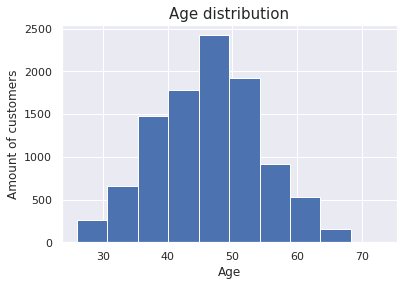

In [11]:
# Checking the overal distribution
data["Customer_Age"].hist()
plt.xlabel("Age")
plt.ylabel("Amount of customers")
plt.title("Age distribution", fontsize=15)
plt.show()

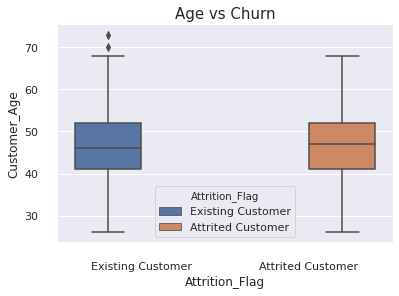

In [12]:
# Comparing the age distribution vs the target
sns.boxplot(x="Attrition_Flag", y="Customer_Age",
            hue="Attrition_Flag", palette=["b", "#DD8452"],
            data=data).set_title("Age vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

The age is normally distributed. There is no clear difference between the age distribution.

### Gender vs churn
Are males of females more eager to churn?

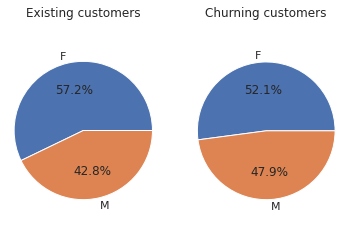

In [13]:
churnedtarget = churned["Gender"].value_counts()
nonchurnedtarget = nonchurned["Gender"].value_counts()

fig1, axs = plt.subplots(1, 2)

axs[0].pie(churnedtarget, labels=churnedtarget.index, autopct='%1.1f%%', shadow=None)
axs[0].axis('equal')
axs[0].set_title('Existing customers')

axs[1].pie(nonchurnedtarget, labels=nonchurnedtarget.index, autopct='%1.1f%%', shadow=None)
axs[1].axis('equal')
axs[1].set_title('Churning customers')

plt.show()

The difference is too small to say that one gender is more eager to churn.

### Number of dependents vs churn

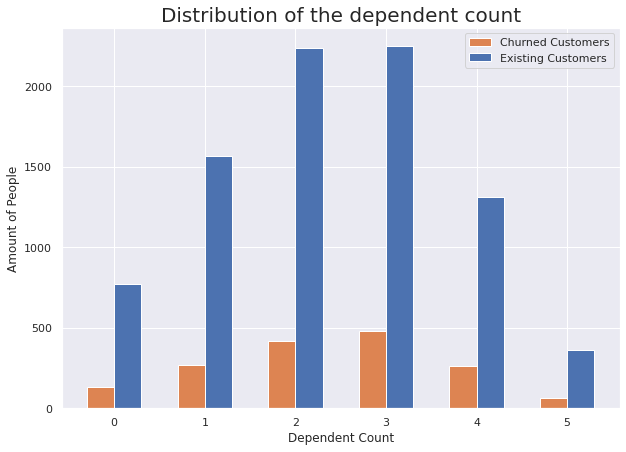

In [14]:
N = 6
ChurnedCounts = churned["Dependent_count"].value_counts().sort_index()
NonChurnedCounts = nonchurned["Dependent_count"].value_counts().sort_index()

ind = np.arange(N)    # the x locations for the groups
width = 0.3       # the width of the bars: can also be len(x) sequence

figs, axs = plt.subplots(figsize=(10,7))

axs.bar(ind - width/2, ChurnedCounts, width, color = "#DD8452")
axs.bar(ind + width/2, NonChurnedCounts, width)

axs.set_xlabel('Dependent Count')
axs.set_ylabel('Amount of People')
axs.set_title('Distribution of the dependent count', fontsize=20)
# axs.set_xticks(ind, ('0', '1', '2', '3', '4', '5'))
axs.legend(('Churned Customers','Existing Customers',))

plt.show()

In [15]:
churned['Dependent_count'].describe()

count    1627.000000
mean        2.402581
std         1.275010
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: Dependent_count, dtype: float64

In [16]:
nonchurned['Dependent_count'].describe()

count    8500.000000
mean        2.335412
std         1.303229
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: Dependent_count, dtype: float64

The dependent count shows us a normal distribution. No clear shift is visible when comparing the churned- and non churned distribution.

### Education level vs churn

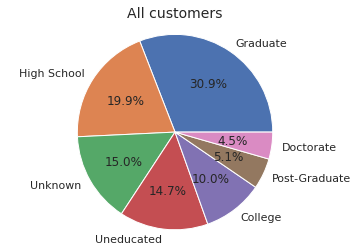

In [17]:
plot_pie("Education_Level")

The majority of people has a graduate education level followed by high school. 15% of the population has an unknown education level.

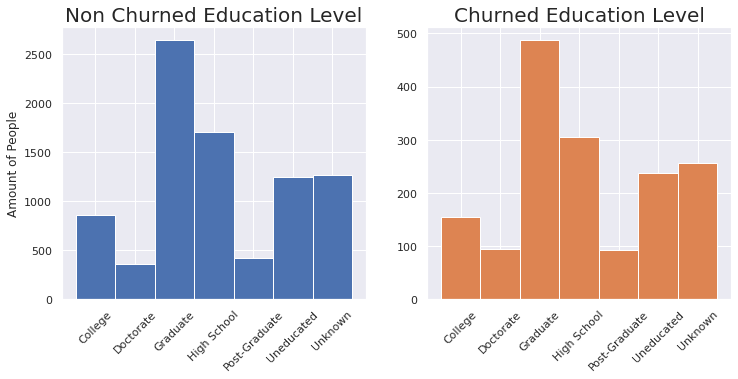

In [18]:
plot_compare("Education_Level", "Education Level")

The "Education level" - distribution of the churn/nonchurned customers shows no difference.

### Marital status vs churn

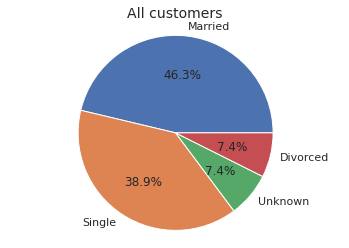

In [19]:
plot_pie("Marital_Status")

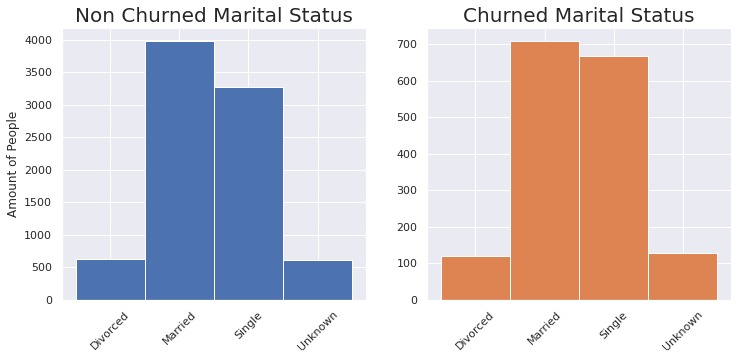

In [20]:
plot_compare("Marital_Status", "Marital Status")

The main part of the population is married. Both churn and non churned have the same distribution.

### Income category vs churn

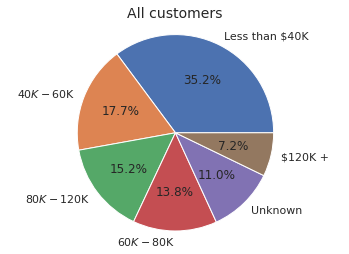

In [21]:
plot_pie("Income_Category")

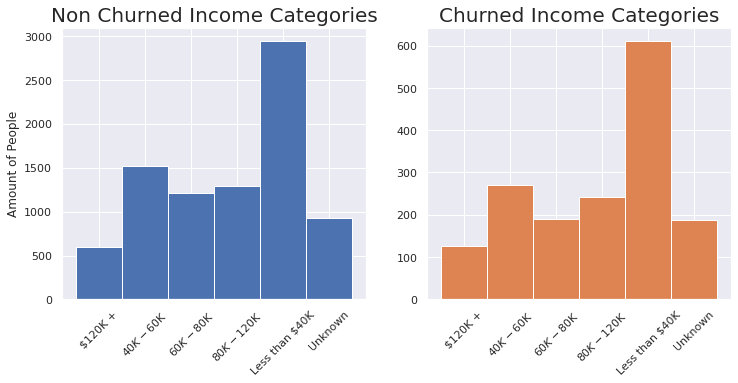

In [22]:
plot_compare("Income_Category", "Income Categories")

We notice that the larget amount of our customers earns less then $40k a year. Like the other demographic variables no clear shift in the distributions can be noticed.

## Checking the product variables
### Types of cards vs churn

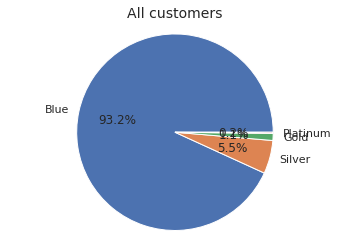

In [23]:
plot_pie("Card_Category")

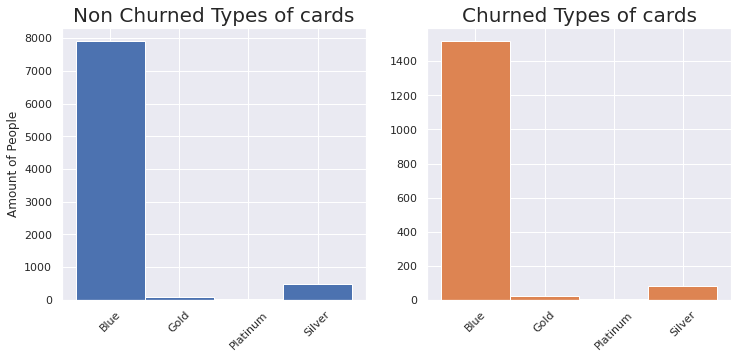

In [24]:
plot_compare("Card_Category", "Types of cards")

We can clearly see that most of our customers have the "Blue" card. The distribution of churned/not churned is the same.

### Relationship with bank vs churn

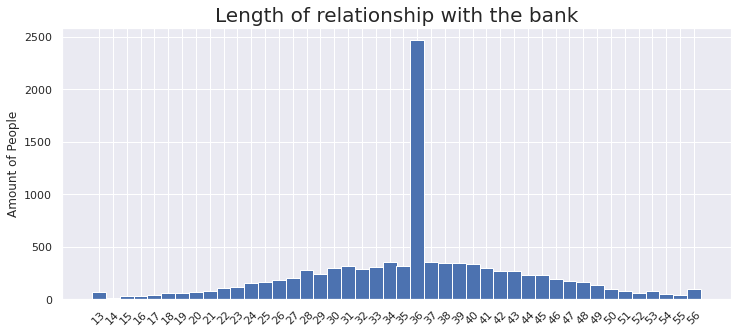

In [25]:
column = "Months_on_book"

N = len(data[column].unique())
DataCounts = data[column].value_counts().sort_index()

ind = np.arange(N) 
width = 1       

figs, axs = plt.subplots(figsize=(12,5))

axs.bar(ind, DataCounts, width, color='b')
axs.set_ylabel('Amount of People')
axs.set_title('Length of relationship with the bank', fontsize=20)
axs.set_xticks(ind)
axs.set_xticklabels(DataCounts.index.tolist(), rotation=45)

plt.show()

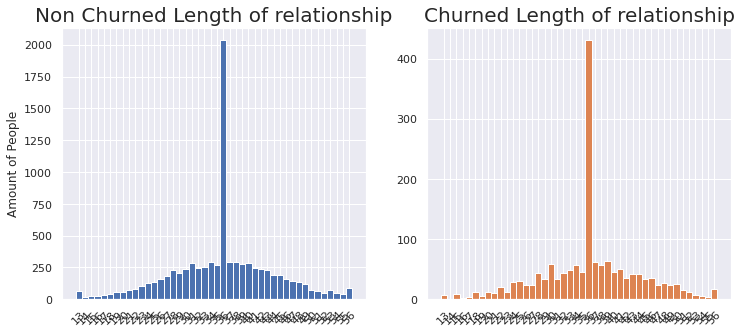

In [26]:
plot_compare("Months_on_book", "Length of relationship")

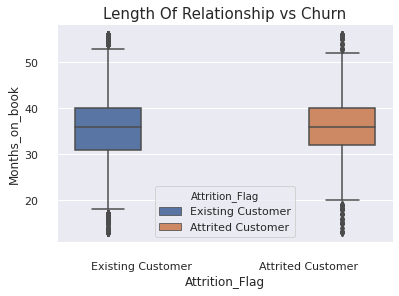

In [27]:
# Comparing the age distribution vs the target
sns.boxplot(x="Attrition_Flag", y="Months_on_book",
            hue="Attrition_Flag", palette=["b", "#DD8452"],
            data=data).set_title("Length Of Relationship vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

### Number of products bought vs churn

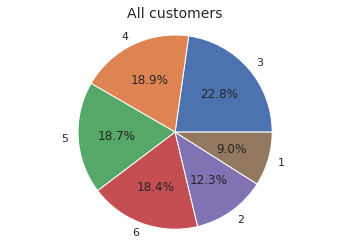

In [28]:
plot_pie("Total_Relationship_Count")

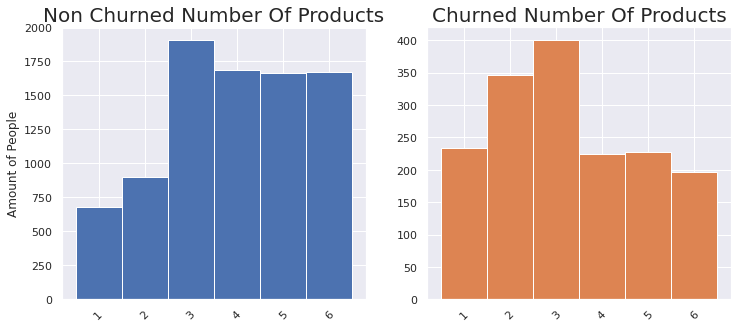

In [29]:
plot_compare("Total_Relationship_Count", "Number Of Products")

Here we see a shift in the distribution when we compare the churned vs the nonchurned. It's clear that the non churned customers tend to buy more products then the churned customers.

### Months inactive vs churn

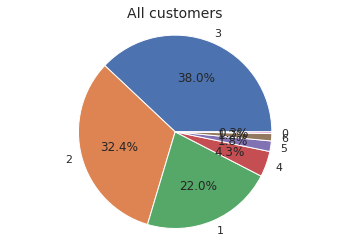

In [30]:
plot_pie("Months_Inactive_12_mon")

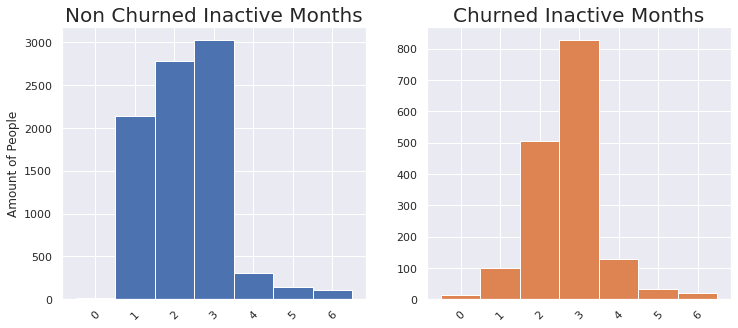

In [31]:
plot_compare("Months_Inactive_12_mon", "Inactive Months")

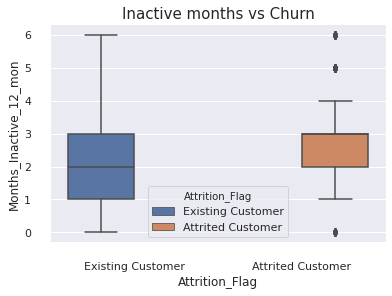

In [32]:
# Comparing the age distribution vs the target
sns.boxplot(x="Attrition_Flag", y="Months_Inactive_12_mon",
            hue="Attrition_Flag", palette=["b", "#DD8452"],
            data=data).set_title("Inactive months vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

It's clear that the most of the customers show a 3 month inactivity. It can be said that most of the active members (less then 3 months) can be found within the non churning customers.

### Number of contacts vs churn

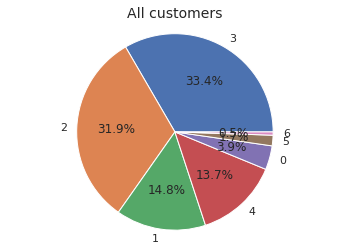

In [33]:
plot_pie("Contacts_Count_12_mon")

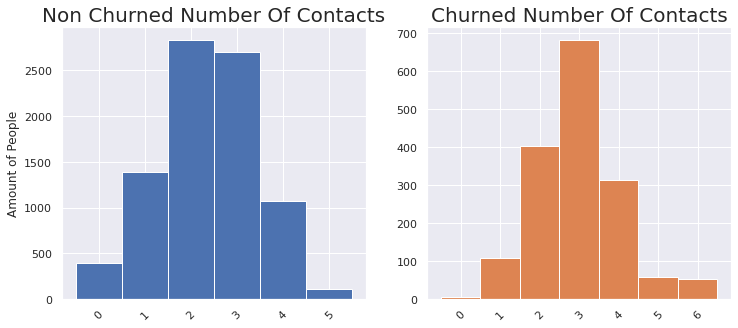

In [34]:
plot_compare("Contacts_Count_12_mon", "Number Of Contacts")

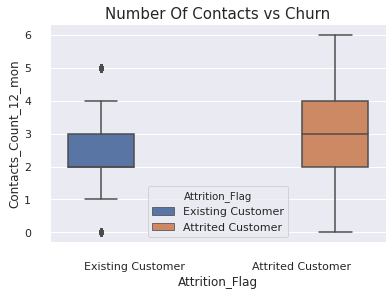

In [35]:
# Comparing the age distribution vs the target
sns.boxplot(x="Attrition_Flag", y="Contacts_Count_12_mon",
            hue="Attrition_Flag", palette=["b", "#DD8452"],
            data=data).set_title("Number Of Contacts vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

Churned customers are most likely to have more contact then the non churned customers. All though the difference isn't large it's still noticable. 

### Credit limit vs churn

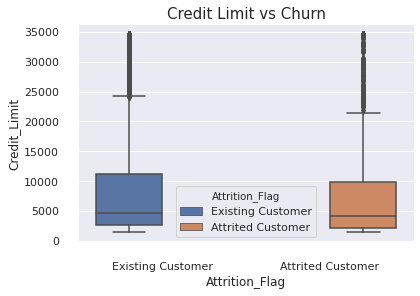

In [36]:
# Comparing the age distribution vs the target
sns.boxplot(x="Attrition_Flag", y="Credit_Limit",
            hue="Attrition_Flag", palette=["b", "#DD8452"],
            data=data).set_title("Credit Limit vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

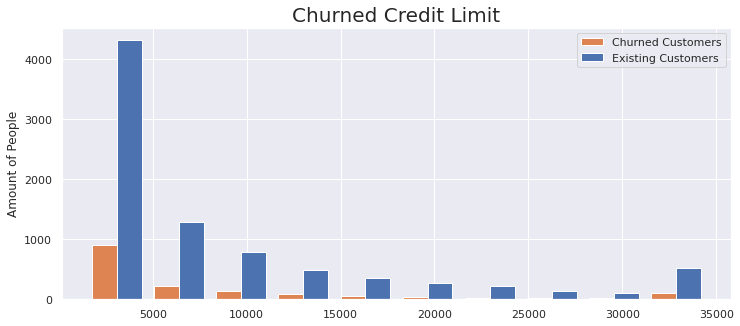

In [37]:
column = "Credit_Limit"
category_name = "Credit Limit" 

NChurned = len(churned[column].unique())
NNonChurned = len(nonchurned[column].unique())

figs, axs = plt.subplots(figsize=(12,5))
    
axs.hist([churned[column], nonchurned[column]] , color=['#DD8452','b'])

axs.set_ylabel('Amount of People')
axs.set_title('Churned ' + category_name, fontsize=20)
axs.legend(('Churned Customers', 'Existing Customers'))


plt.show()

There is no clear difference in the credit limit.

### Total revolving balance vs churn

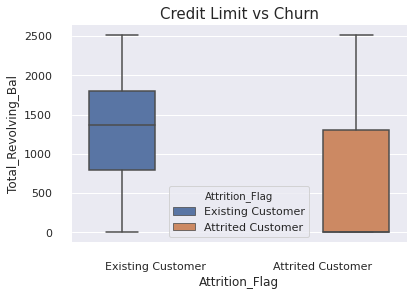

In [38]:
# Comparing the age distribution vs the target
sns.boxplot(x="Attrition_Flag", y="Total_Revolving_Bal",
            hue="Attrition_Flag", palette=["b", "#DD8452"],
            data=data).set_title("Credit Limit vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

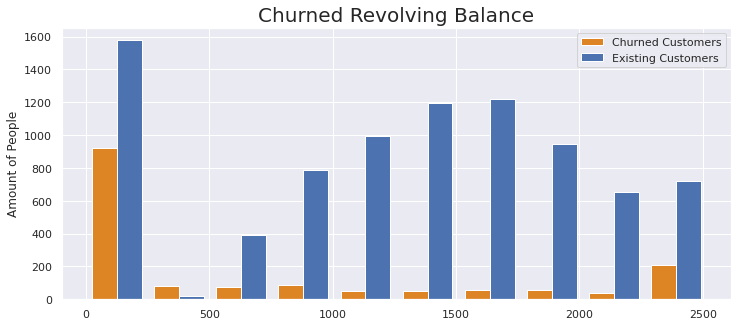

In [39]:
column = "Total_Revolving_Bal"
category_name = "Revolving Balance" 

NChurned = len(churned[column].unique())
NNonChurned = len(nonchurned[column].unique())

figs, axs = plt.subplots(figsize=(12,5))
    
axs.hist([churned[column], nonchurned[column]] , color=['#DD8425', 'b'])

axs.set_ylabel('Amount of People')
axs.set_title('Churned ' + category_name, fontsize=20)
axs.legend(('Churned Customers', 'Existing Customers'))


plt.show()

It's clear that the churned customers have a lower revolving balance then the existing customers.

### Openness To Buy Credit Line vs churn

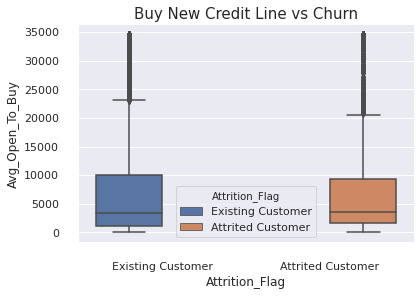

In [40]:
# Comparing the age distribution vs the target
sns.boxplot(x="Attrition_Flag", y="Avg_Open_To_Buy",
            hue="Attrition_Flag", palette=["b", "#DD8452"],
            data=data).set_title("Buy New Credit Line vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

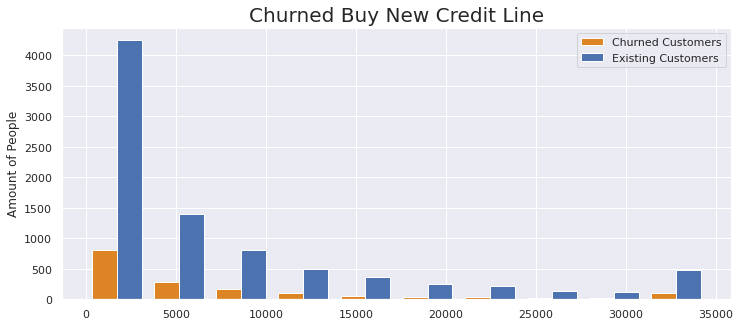

In [41]:
column = "Avg_Open_To_Buy"
category_name = "Buy New Credit Line" 

NChurned = len(churned[column].unique())
NNonChurned = len(nonchurned[column].unique())

figs, axs = plt.subplots(figsize=(12,5))
    
axs.hist([churned[column], nonchurned[column]] , color=['#DD8425', 'b'])

axs.set_ylabel('Amount of People')
axs.set_title('Churned ' + category_name, fontsize=20)
axs.legend(('Churned Customers', 'Existing Customers'))


plt.show()

No distinctive difference.


### Change in Transaction vs Churn

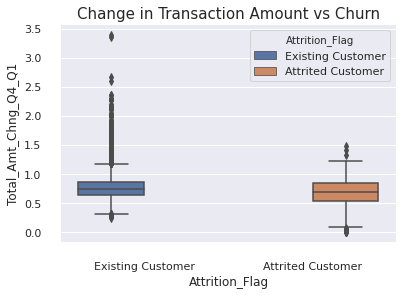

In [42]:
sns.boxplot(x="Attrition_Flag", y="Total_Amt_Chng_Q4_Q1",
            hue="Attrition_Flag", palette=["b", "#DD8452"],
            data=data).set_title("Change in Transaction Amount vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

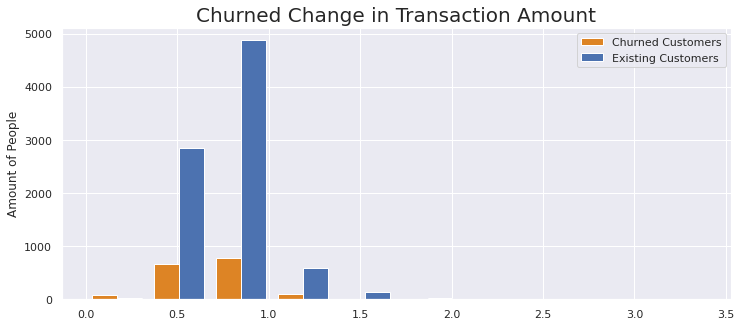

In [43]:
column = "Total_Amt_Chng_Q4_Q1"
category_name = "Change in Transaction Amount" 

NChurned = len(churned[column].unique())
NNonChurned = len(nonchurned[column].unique())

figs, axs = plt.subplots(figsize=(12,5))
    
axs.hist([churned[column], nonchurned[column]] , color=[ '#DD8425','b'])

axs.set_ylabel('Amount of People')
axs.set_title('Churned ' + category_name, fontsize=20)
axs.legend(('Churned Customers', 'Existing Customers'))


plt.show()

No clear difference.

### Total transaction amount vs churn

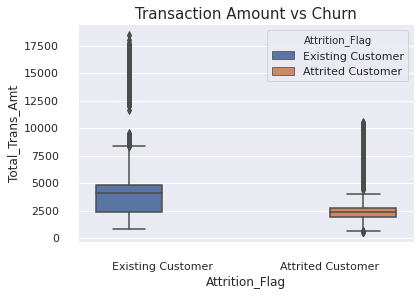

In [44]:
sns.boxplot(x="Attrition_Flag", y="Total_Trans_Amt",
            hue="Attrition_Flag", palette=["b", "#DD8452"],
            data=data).set_title("Transaction Amount vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

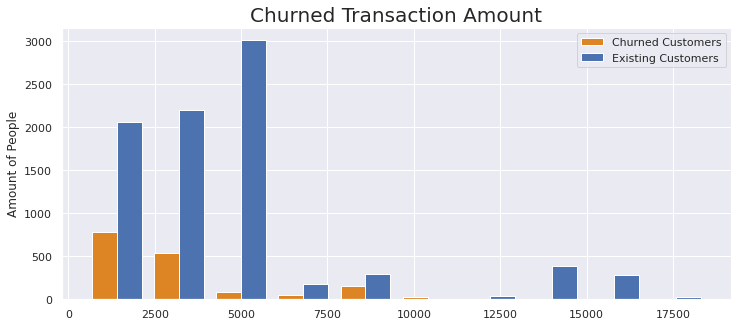

In [45]:
column = "Total_Trans_Amt"
category_name = "Transaction Amount" 

NChurned = len(churned[column].unique())
NNonChurned = len(nonchurned[column].unique())

figs, axs = plt.subplots(figsize=(12,5))
    
axs.hist([churned[column], nonchurned[column]] , color=[ '#DD8425','b'])

axs.set_ylabel('Amount of People')
axs.set_title('Churned ' + category_name, fontsize=20)
axs.legend(('Churned Customers', 'Existing Customers'))


plt.show()

It's clear that the transaction amount is lower for the churned customers compared to the existing customers.

### Total transaction count vs Churn 

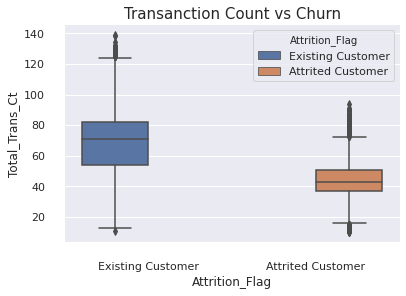

In [46]:
sns.boxplot(x="Attrition_Flag", y="Total_Trans_Ct",
            hue="Attrition_Flag", palette=["b", "#DD8452"],
            data=data).set_title("Transanction Count vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

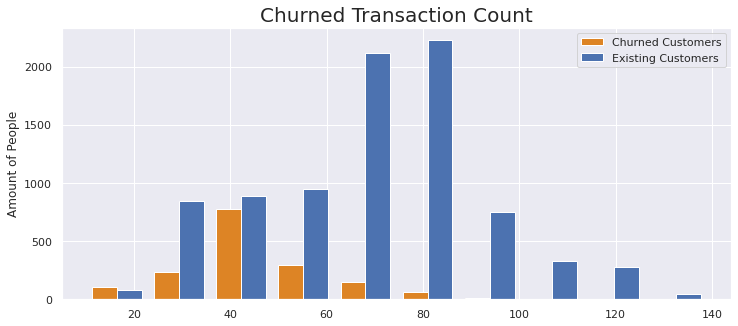

In [47]:
column = "Total_Trans_Ct"
category_name = "Transaction Count" 

NChurned = len(churned[column].unique())
NNonChurned = len(nonchurned[column].unique())

figs, axs = plt.subplots(figsize=(12,5))
    
axs.hist([churned[column], nonchurned[column]] , color=[ '#DD8425','b'])

axs.set_ylabel('Amount of People')
axs.set_title('Churned ' + category_name, fontsize=20)
axs.legend(('Churned Customers', 'Existing Customers'))


plt.show()

It's clear that churned customers mostly have a lower transaction count then the existing customers.

### Change in transaction count vs Churn

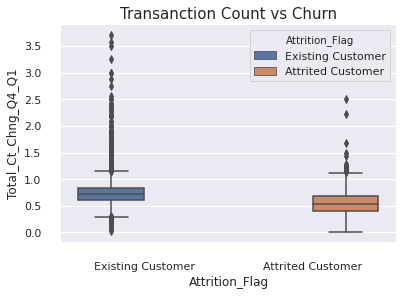

In [48]:
sns.boxplot(x="Attrition_Flag", y="Total_Ct_Chng_Q4_Q1",
            hue="Attrition_Flag", palette=["b", "#DD8452"],
            data=data).set_title("Transanction Count vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

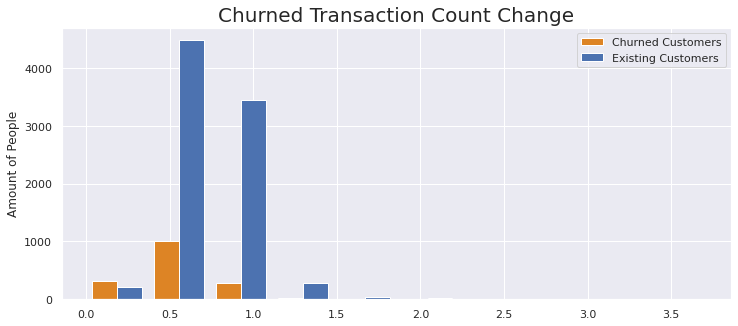

In [49]:
column = "Total_Ct_Chng_Q4_Q1"
category_name = "Transaction Count Change" 

NChurned = len(churned[column].unique())
NNonChurned = len(nonchurned[column].unique())

figs, axs = plt.subplots(figsize=(12,5))
    
axs.hist([churned[column], nonchurned[column]] , color=['#DD8425','b'])

axs.set_ylabel('Amount of People')
axs.set_title('Churned ' + category_name, fontsize=20)
axs.legend(('Churned Customers', 'Existing Customers'))

plt.show()

Again there's a clear difference between in the distribution. The average is higher for the existing customers.

### Average Card Utilization Ratio

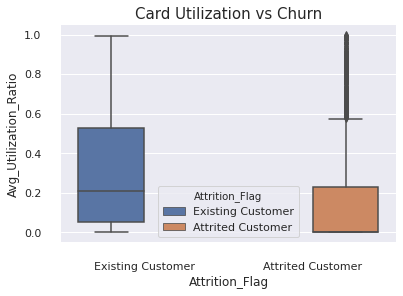

In [50]:
sns.boxplot(x="Attrition_Flag", y="Avg_Utilization_Ratio",
            hue="Attrition_Flag", palette=["b", "#DD8452"],
            data=data).set_title("Card Utilization vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

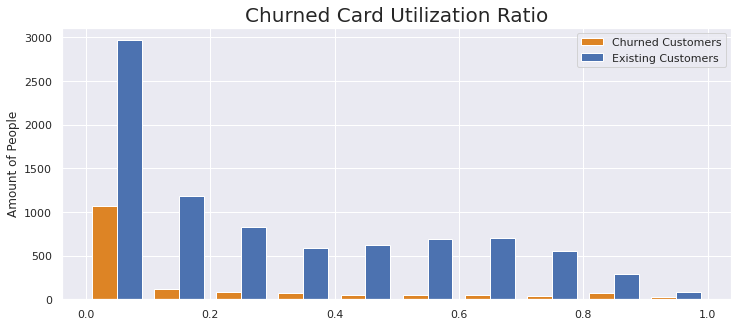

In [51]:
column = "Avg_Utilization_Ratio"
category_name = "Card Utilization Ratio" 

NChurned = len(churned[column].unique())
NNonChurned = len(nonchurned[column].unique())

figs, axs = plt.subplots(figsize=(12,5))
    
axs.hist([churned[column], nonchurned[column]] , color=['#DD8425','b'])

axs.set_ylabel('Amount of People')
axs.set_title('Churned ' + category_name, fontsize=20)
axs.legend(('Churned Customers', 'Existing Customers'))

plt.show()

It's clear that the average card utilization ratio is higher for the existing customers.

<a id="Profiles"></a> 
## 3.2. Non Churn and Churn Profiles

According to the EDA above, the profiles underneed can be made. It's clear that the main difference lays in the "product variables" of the customers. A churning customers tends to be less active then an existing customer. It's clear that the most influential parameters are features related to the activity of the customer.


|            |  Non Churning Customer | Churning Customer | 
|:----------:|:-------------:|:--------:|
||||
| ***Demographic variables*** |
| Age | 47 | 46 | 
| Gender | F/M | F/M |
| Dependents | 2 | 2 |
| Education Level | Graduate | Graduate |
| Marital Level | Married/Single | Married/Single |
| Income Category | Less then \$40K | Less  then \$40K |
||||
| ***Product variables*** |
| Type Of Card | Blue | Blue |
| Length Of Relationship | 36 months | 36 months |
| Products Bought | 4 | 3 |
| Inactive Months | 2 | 3 |
| Number Of Contact | 2 | 3 |
| Credit Limit | \$8726 | \$8136 |
| Revolving Balance | 1256 | 672 |
| Open To Buy Credit Line | 7470 | 7463 |
| Transaction Amount Change | 0.77 | 0.69 |
| Total Transaction Amount | 4650 | 3095 |
| Total Transaction Count | 69 | 45 |
| Transaction Count Change | 0.74 | 0.55 |
| Card Utilization Ratio | 0.3 | 0.16 |

In [52]:
churned.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000
mean,46.659496,2.402581,36.178242,3.279656,2.693301,2.972342,8136.039459,672.822987,7463.216472,0.694277,3095.025814,44.933620,0.554386,0.162475
std,7.665652,1.275010,7.796548,1.577782,0.899623,1.090537,9095.334105,921.385582,9109.208129,0.214924,2308.227629,14.568429,0.226854,0.264458
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,2.000000,32.000000,2.000000,2.000000,2.000000,2114.000000,0.000000,1587.000000,0.544500,1903.500000,37.000000,0.400000,0.000000
50%,47.000000,2.000000,36.000000,3.000000,3.000000,3.000000,4178.000000,0.000000,3488.000000,0.701000,2329.000000,43.000000,0.531000,0.000000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,4.000000,9933.500000,1303.500000,9257.500000,0.856000,2772.000000,51.000000,0.692000,0.231000
max,68.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,1.492000,10583.000000,94.000000,2.500000,0.999000


In [53]:
nonchurned.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000
mean,46.262118,2.335412,35.880588,3.914588,2.273765,2.356353,8726.877518,1256.604118,7470.273400,0.772510,4654.655882,68.672588,0.742434,0.296412
std,8.081157,1.303229,8.021810,1.528949,1.016741,1.081436,9084.969807,757.745354,9087.671862,0.217783,3512.772635,22.919011,0.228054,0.272568
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,15.000000,0.256000,816.000000,11.000000,0.028000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,1.000000,2.000000,2602.000000,800.000000,1184.500000,0.643000,2384.750000,54.000000,0.617000,0.055000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4643.500000,1364.000000,3469.500000,0.743000,4100.000000,71.000000,0.721000,0.211000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11252.750000,1807.000000,9978.250000,0.860000,4781.250000,82.000000,0.833000,0.529250
max,73.000000,5.000000,56.000000,6.000000,6.000000,5.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.994000


<a id="CustomerChurnPrediction"></a>
# 4. Customer Churn Prediction
Here we will train an optimized (treebased) model which will predict if a customer will or won't churn. 

<a id="DataPrep"></a>
## 4.1. Data Preperation
Before we start training a model we must prepare our data. Different steps that we can undertake:
* Encode all categorical data (watch out with one hot encoding and tree-based models...).
* Scale data
* Check correlation matrix to extract the most influential features.
* Generate new columns from data.
* Upsample the imbalanced dataset (SMOTE/ADASYN).

In this notebook we shall focus on the upsampling method. The data wrangling performed is to make sure that the upsampling is performed in a correct manner.



### SMOTE (Synthetic Minority Oversampling Technique)
We saw that our dataset was imbalanced. This could gives problems when creating a classification model since it might not learn the decision boundary. This ofcourse an be solved with upsampling.

One technique used for this is SMOTE, this technique creates new synthetic samples which can be used for training.

> SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.
[SMOTE Paper](https://arxiv.org/abs/1106.1813)

To use SMOTE we'll need to encode our categorical features.

Note: It's important to only upsample the training data and so that no synthetic data is present in the validation dataset.

In [54]:
encoder = LabelEncoder()

def make_categorical(data: pd.DataFrame, column: str, categories: list, ordered: bool = False):
    data[column] = pd.Categorical(data[column], categories=categories, ordered=ordered)

In [55]:
make_categorical(data, 'Marital_Status', ['Unknown', 'Single', 'Divorced','Married'])

make_categorical(data, 'Income_Category', ['Unknown','Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +'], True)

make_categorical(data, 'Card_Category', ['Blue', 'Silver', 'Gold', 'Platinum'], True)

In [56]:
data["Attrition_Flag"] = data["Attrition_Flag"].replace({'Attrited Customer':1,'Existing Customer':0})
data["Gender"] = data["Gender"].replace({'F':1,'M':0})

In [57]:
ClassesToEncode = ['Education_Level' ,'Marital_Status', 'Income_Category', 'Card_Category']

In [58]:
for Class in ClassesToEncode:
    data[Class] = encoder.fit_transform(data[Class])

In [59]:
y_data = data["Attrition_Flag"]
X_data = data.drop(columns = ["Attrition_Flag"])

In [60]:
# for testing purposes
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

In [61]:
# Transform the dataset (only training data)
oversample = SMOTE()
X_up, y_up = oversample.fit_resample(X_train, y_train)

<a id="ModelTraining"></a>
## 4.2. Model Training
RandomForest and XGBoost

### RandomForestClassifier

In [62]:
rf = RandomForestClassifier()
rf.fit(X_up, y_up)

RandomForestClassifier()

### XGBClassifier

In [63]:
xgb = XGBClassifier()
xgb.fit(X_up, y_up)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<a id="ModelEvaluation"></a>
## 4.3. Model Evaluation

### RandomForestClassifier

In [64]:
rfpred = rf.predict(X_test)
print(classification_report(y_test, rfpred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2583
           1       0.83      0.89      0.86       456

    accuracy                           0.96      3039
   macro avg       0.90      0.93      0.92      3039
weighted avg       0.96      0.96      0.96      3039



In [65]:

ypred = rfpred
model = rf
print ('Confusion Matrix:')
print(confusion_matrix(y_test, ypred))
print('\nAccuracy:', accuracy_score(y_test, ypred))
print("Overall Precision:",precision_score(y_test, ypred))
print("Overall Recall:",recall_score(y_test, ypred))
print("Overall f1-score:", f1_score(y_test, ypred))
auc = roc_auc_score(y_test,ypred)
plt.show()

Confusion Matrix:
[[2497   86]
 [  50  406]]

Accuracy: 0.9552484369858506
Overall Precision: 0.8252032520325203
Overall Recall: 0.8903508771929824
Overall f1-score: 0.8565400843881856


### XGBClassifier

In [66]:
xgbpred = xgb.predict(X_test)
print(classification_report(y_test, xgbpred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2583
           1       0.87      0.91      0.89       456

    accuracy                           0.97      3039
   macro avg       0.93      0.94      0.94      3039
weighted avg       0.97      0.97      0.97      3039



In [67]:

ypred = xgbpred
model = xgb
print ('Confusion Matrix:')
print(confusion_matrix(y_test, ypred))
print('\nAccuracy:', accuracy_score(y_test, ypred))
print("Overall Precision:",precision_score(y_test, ypred))
print("Overall Recall:",recall_score(y_test, ypred))
print("Overall f1-score:", f1_score(y_test, ypred))
auc = roc_auc_score(y_test,ypred)
plt.show()

Confusion Matrix:
[[2523   60]
 [  40  416]]

Accuracy: 0.9670944389601843
Overall Precision: 0.8739495798319328
Overall Recall: 0.9122807017543859
Overall f1-score: 0.8927038626609443


It's clear that the performance XGBoostClassifier is better.
With a recall of 92.5 % we clearly reached our goal. ( goal: ... > 0.62 )

<a id="Hyperparameter"></a>
## 4.4. Hyperparameter tuning

### RandomizedSearchCV

First we'll use a RandomizedSearchCV to find narrow down on the most optimal parameters. For further finetuning GridSearchCV will be used.


In [68]:
# Tuning hyperparameters with RandomizedSearchCV

#params = {
#    "colsample_bytree": uniform(0.3, 0.7),
#    "min_child_weight": [1,2,3,4],
#    "learning_rate": uniform(0.1, 0.5), # default 0.1 
#    "max_depth": randint(6, 9), # default 3
#    "n_estimators": randint(100, 300), # default 100
#    "subsample": uniform(0.6, 0.4)
#}
#xgbnew = XGBClassifier()

#search = RandomizedSearchCV(xgbnew, param_distributions=params, random_state=123, n_iter=100, cv=3, verbose=2, n_jobs=-1)

#search.fit(X_up, y_up)

In [69]:
#search.best_params_

In [70]:
#myxgb = search.best_estimator_
#thisypred = myxgb.predict(X_test)

#print(classification_report(y_test, thisypred))

In [71]:
# Parameters from RandomizedSearchCV
#{'colsample_bytree': 0.7025947001725772,
# 'learning_rate': 0.2612838738188591,
# 'max_depth': 7,
# 'min_child_weight': 1,
# 'n_estimators': 229,
# 'subsample': 0.8518910536188189}

myxgb = XGBClassifier(colsample_bytree=0.7025947001725772, learning_rate= 0.2612838738188591,max_depth= 7,min_child_weight=1, n_estimators = 229, subsample = 0.8518910536188189 )
myxgb.fit(X_up, y_up)
thisypred = myxgb.predict(X_test)


ypred = thisypred
model = myxgb
print ('Confusion Matrix:')
print(confusion_matrix(y_test, ypred))
print('Accuracy:', accuracy_score(y_test, ypred))
print("Overall Precision:",precision_score(y_test, ypred))
print("Overall Recall:",recall_score(y_test, ypred))
auc = roc_auc_score(y_test,ypred)

print("AUC:", auc)
plt.show()

Confusion Matrix:
[[2519   64]
 [  36  420]]
Accuracy: 0.9670944389601843
Overall Precision: 0.8677685950413223
Overall Recall: 0.9210526315789473
AUC: 0.9481376204739491


### GridSearchCV

In [72]:
# GridSearchCV for finetuning

#params = {
#    "colsample_bytree": [0.670, 0.680, 0.690],
#    "min_child_weight": [1],
#    "learning_rate": [0.275, 0.3, 0.325], # default 0.1 
#    "max_depth": [7,8,9], # default 3
#    "n_estimators": [212, 215, 217], # default 100
#    "subsample": [0.75, 0.80, 0.85]
#}

#gridxgb = XGBClassifier()

#gridsearch = GridSearchCV(estimator = gridxgb, param_grid = params, cv = 3, n_jobs = -1, verbose = 2)

#gridsearch.fit(X_up, y_up)

In [73]:
#gridsearch.best_params_

In [74]:
#mymodel = gridsearch.best_estimator_
#mymodelpred = mymodel.predict(X_test)
#recall_score(y_test, mymodelpred)

In [75]:
# {'colsample_bytree': 0.67,
# 'learning_rate': 0.3,
# 'max_depth': 8,
# 'min_child_weight': 1,
# 'n_estimators': 215,
# 'subsample': 0.8}

mymodel = XGBClassifier(colsample_bytree = 0.67, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=215, subsample=0.8)
mymodel.fit(X_up, y_up)
mymodelpred = mymodel.predict(X_test)

ypred = mymodelpred
model = mymodel
print ('Confusion Matrix:')
print(confusion_matrix(y_test, ypred))
print('Accuracy:', accuracy_score(y_test, ypred))
print("Overall Precision:",precision_score(y_test, ypred))
print("Overall Recall:",recall_score(y_test, ypred))
auc = roc_auc_score(y_test,ypred)

print("AUC:", auc)
plt.show()

Confusion Matrix:
[[2516   67]
 [  37  419]]
Accuracy: 0.9657782165185916
Overall Precision: 0.8621399176954733
Overall Recall: 0.918859649122807
AUC: 0.9464604091529637


<a id="FeatureImportance"></a>
## 4.5. Feature Importance
In this step we'll have a look at the relative importance of each feature used in the predictions.

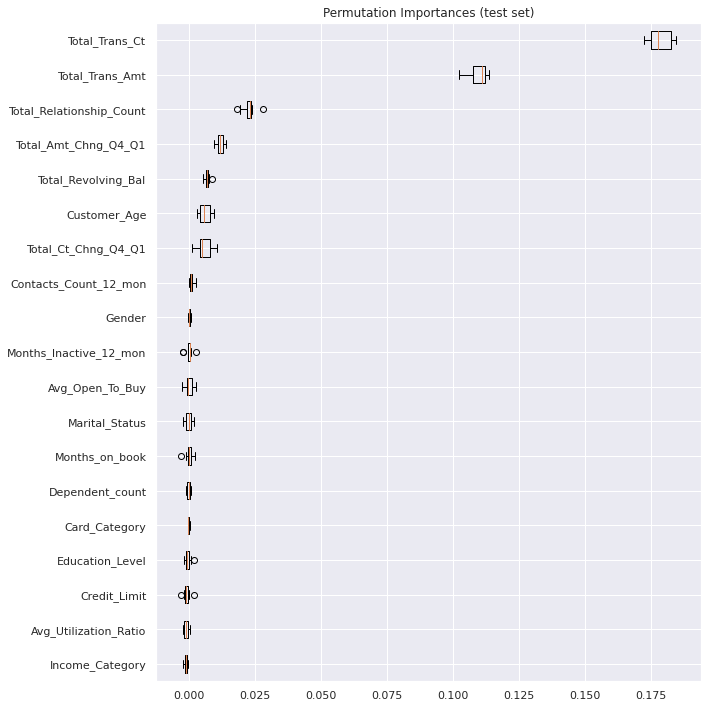

In [76]:
resultmymodel = permutation_importance(mymodel, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = resultmymodel.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(resultmymodel.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Like we noticed in the EDA the top 3 most important features are within the product variables, more specifically: "Total_Trans_Ct", "Total_Trans_Amt", "Total_Amt_Chng_Q4_Q1".

<a id="Conclusion"></a>
## 5. Conclusion

We can conclude that the top 3 most influential features are the product variables: "Total_Trans_Ct", "Total_Trans_Amt", "Total_Amt_Chng_Q4_Q1". Using the existing data we managed to train a model with upsampled data which reaches a recall score of 92%.


### Future improvements
* Use correlation matrix in EDA to find the most influential features.
* Use iterative imputer to get rid of the "Unknown" values?
* Use PCA for feature selection.
* Create a training and inferencing pipeline.
* Data Upsampling with ADASYN instead of SMOTE
